In [259]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import matplotlib.lines as mlines
from fredapi import Fred
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as st

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [260]:
import warnings
warnings.filterwarnings('ignore')

In [261]:
#1
data = pd.read_csv('A1_JPYUSD.csv', parse_dates = True, index_col = 0)

In [262]:
data

,date,Japan
0,1985/1/1,0.003927
1,1985/2/1,0.003854
2,1985/3/1,0.003960
3,1985/4/1,0.003964
4,1985/5/1,0.003971
...,...,...
450,2022/7/1,0.007519
451,2022/8/1,0.007214
452,2022/9/1,0.006909
453,2022/10/1,0.006746


In [263]:
455*0.8

364.0

In [264]:
data1=data.iloc[:364,:]
data2=data.iloc[364:456,:]

In [265]:
#1.(a)
import pmdarima as pm
arima = pm.auto_arima(data1['Japan'], start_p = 0, start_q = 0,
                      suppress_warnings=True)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:               SARIMAX(2, 1, 0)   Log Likelihood                2462.692
Date:                Tue, 24 Jan 2023   AIC                          -4919.383
Time:                        16:51:25   BIC                          -4907.700
Sample:                             0   HQIC                         -4914.739
                                - 364                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0900      0.045      2.018      0.044       0.003       0.177
ar.L2          0.0947      0.050      1.898      0.058      -0.003       0.192
sigma2      7.494e-08   4.22e-09     17.775      0.000    6.67e-08    8.32e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                39.98
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.12
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The appropriate hyperparameters for an ARIMA(p,d,q) for making forecasts of the JPYUSD series is (2,1,0).

In [266]:
#1.(b)
# prepare training dataset
X=data['Japan']
arima_order=(2,1,0)
train_size = int(len(X) * 0.8)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
yhatlist=list()
lower=list()
upper=list()
for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat1=model_fit.get_forecast(1)
    yhat_conf_int = yhat1.conf_int(alpha=0.1)
    yhatlist.append(yhat)
    lower.append(yhat_conf_int[0,0])
    upper.append(yhat_conf_int[0,1])
    history.append(test[t+364])
# calculate out of sample error
test = pd.DataFrame(test)
test["predictions"] = yhatlist
test['lower']=lower
test['upper']=upper
test

,Japan,predictions,lower,upper
364,0.008081,0.008443,0.007992,0.008893
365,0.008167,0.008060,0.007609,0.008510
366,0.008066,0.008140,0.007690,0.008590
367,0.008251,0.008066,0.007616,0.008516
368,0.008337,0.008257,0.007808,0.008706
...,...,...,...,...
450,0.007519,0.007285,0.006856,0.007715
451,0.007214,0.007491,0.007062,0.007921
452,0.006909,0.007208,0.006779,0.007638
453,0.006746,0.006853,0.006424,0.007283


In [270]:
#1.(c)
y=test

# compute whether we are going long or short
y["Signals"] = np.where(y["predictions"]>y['Japan'].shift(), 1,-1)

# get the series of log returns
y["returns"] = np.log(y["Japan"]/y["Japan"].shift())

# compute the long and short returns
y["strategy returns"] = y["Signals"]*y["returns"] 

# convert to simple returns
y["Cumulative Returns"] = (np.exp(y["strategy returns"].cumsum())-1)*100

In [271]:
y

,Japan,predictions,lower,upper,Signals,returns,strategy returns,Cumulative Returns
364,0.008081,0.008443,0.007992,0.008893,-1,NaN,NaN,NaN
365,0.008167,0.008060,0.007609,0.008510,-1,0.010561,-0.010561,-1.050511
366,0.008066,0.008140,0.007690,0.008590,-1,-0.012337,0.012337,0.177773
367,0.008251,0.008066,0.007616,0.008516,-1,0.022597,-0.022597,-2.060606
368,0.008337,0.008257,0.007808,0.008706,1,0.010367,0.010367,-1.039978
...,...,...,...,...,...,...,...,...
450,0.007519,0.007285,0.006856,0.007715,-1,0.026927,-0.026927,34.116373
451,0.007214,0.007491,0.007062,0.007921,-1,-0.041315,0.041315,39.773456
452,0.006909,0.007208,0.006779,0.007638,-1,-0.043275,0.043275,45.954920
453,0.006746,0.006853,0.006424,0.007283,-1,-0.023893,0.023893,49.484285


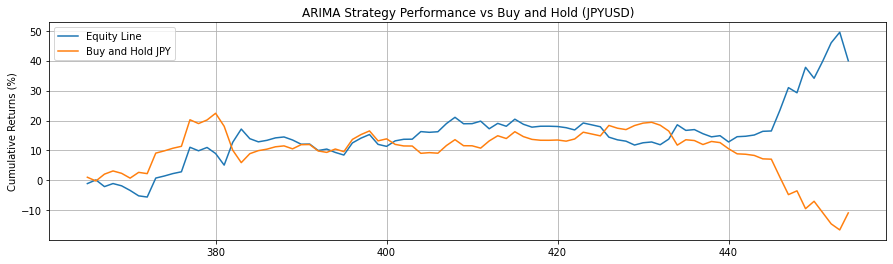

In [272]:
plt.figure(figsize = (15, 4))
plt.plot(y["Cumulative Returns"])
plt.plot((np.exp(y["returns"].cumsum())-1)*100)
plt.ylabel("Cumulative Returns (%)")
plt.title("ARIMA Strategy Performance vs Buy and Hold (JPYUSD)")
plt.legend(["Equity Line", "Buy and Hold JPY"])
plt.grid()

In [273]:
#1.(d)
# compounded
P = 1000000
A = (((y["Cumulative Returns"]/100)+1)*P)[454]
t = (len(y)/12)
CCROR = np.log(A/P)/t
print(CCROR*100)

4.433704686010043


In [274]:
# Annualized 
ar=((A/P)**(1/t)-1)*100
ar

4.533462227199214

The continuously compounded return is 4.43%, and annualized return is 4.53%.

In [275]:
#2
data2 = pd.read_csv('1-year-treasury-rate-yield-chart.csv', parse_dates = True, index_col = 0)

In [276]:
### Data Cleaning
## Dependent Variable : s_t+1, s_t
# s_current : log of nominal exchange rates at t
s_current = data.loc[0:len(data)-1,'Japan'].reset_index(drop=True)
s_current = s_current.rename('s_current')


# s_future : log of nominal exchange rates at t+1
s_future = data.loc[1:,'Japan'].reset_index(drop=True)
s_future = s_future.rename('s_future')


# s_change : change in log of exchange rates (s_t+1 - s_t)
s_change = s_future - s_current
s_change = s_change.rename('s_change')

In [277]:
japan_const=data

# Combine all variables into a new data set
japan_const['s_future'] = s_future
japan_const['s_current'] = s_current
japan_const['s_change'] = s_change.shift()

japan_const.head()

,date,Japan,s_future,s_current,s_change
0,1985/1/1,0.003927,0.003854,0.003927,NaN
1,1985/2/1,0.003854,0.003960,0.003854,-0.000073
2,1985/3/1,0.003960,0.003964,0.003960,0.000107
3,1985/4/1,0.003964,0.003971,0.003964,0.000004
4,1985/5/1,0.003971,0.004017,0.003971,0.000006


In [278]:
japan3=japan_const.iloc[364:455,:]
japan3['s_forecast']=test['predictions']
# Forecast Error
japan3['error'] = japan3['s_forecast']-japan3['s_current']
japan3['s_change_fitted']=japan3['s_forecast']-japan3["s_current"].shift()
japan3

,date,Japan,s_future,s_current,s_change,s_forecast,error,s_change_fitted
364,2015/5/1,0.008081,0.008167,0.008081,-0.000357,0.008443,0.000362,NaN
365,2015/6/1,0.008167,0.008066,0.008167,0.000086,0.008060,-0.000107,-2.085774e-05
366,2015/7/1,0.008066,0.008251,0.008066,-0.000100,0.008140,0.000073,-2.690062e-05
367,2015/8/1,0.008251,0.008337,0.008251,0.000184,0.008066,-0.000185,-3.475848e-07
368,2015/9/1,0.008337,0.008273,0.008337,0.000086,0.008257,-0.000080,6.060382e-06
...,...,...,...,...,...,...,...,...
450,2022/7/1,0.007519,0.007214,0.007519,0.000200,0.007285,-0.000234,-3.383869e-05
451,2022/8/1,0.007214,0.006909,0.007214,-0.000304,0.007491,0.000277,-2.756805e-05
452,2022/9/1,0.006909,0.006746,0.006909,-0.000306,0.007208,0.000299,-6.056732e-06
453,2022/10/1,0.006746,0.007205,0.006746,-0.000163,0.006853,0.000108,-5.557996e-05


In [279]:
### Mean squared errors
P = len(japan3)
MSE_T = np.sum(np.square(japan3['error']))/P
MSE_T

4.3592630517413226e-08

In [280]:
## Random Walk
MSE_R = np.sum(np.square(japan3['s_change']))/P
MSE_R

4.370158452976924e-08

In [281]:
### 2.(a). DMW test
## V_hat
error_R = japan3['s_change'].reset_index(drop=True)
error_T = japan3['error'].reset_index(drop=True)
tmp = np.square(error_R) - np.square(error_T) - (MSE_R - MSE_T)
V_hat = np.sum(np.square(tmp))/P

## Statistic
DMW = (MSE_R - MSE_T)/np.sqrt(V_hat/P)

print('Since the DMW statitsic is equal to ' + str(DMW) + ',' + ' which is less than the critical value (' + str(round(st.norm.ppf(.95),2)) + '),')
print('we fail to reject the null hypothesis that the strategy model does not outperform the random walk model.')

Since the DMW statitsic is equal to 0.08421825011783572, which is less than the critical value (1.64),
we fail to reject the null hypothesis that the strategy model does not outperform the random walk model.


In [282]:
### 2.(b). CW statistic
tmp2 = np.sum(np.square(japan3['s_change_fitted']))/P
CW = (MSE_R - MSE_T + tmp2)/np.sqrt(V_hat/P)

print('Since the CW statitsic is equal to ' + str(CW) + ',' + ' which is less than the critical value (' + str(round(st.norm.ppf(.95),2)) + '),')
print('we fail to reject the null hypothesis that the strategy model does not outperform the random walk model.')

Since the CW statitsic is equal to 0.6629726451707499, which is less than the critical value (1.64),
we fail to reject the null hypothesis that the strategy model does not outperform the random walk model.


In [283]:
#2.(c)
# download data on the assumed risk free rate
rf_rate = pd.read_csv("1-year-treasury-rate-yield-chart.csv", index_col = 0, parse_dates = True).dropna()
rf_rate

,value
date,
1962-01-02,3.22
1962-01-03,3.24
1962-01-04,3.24
1962-01-05,3.26
1962-01-08,3.31
...,...
2022-12-16,4.61
2022-12-19,4.64
2022-12-20,4.64


In [284]:
# match index and dates with our data
drange = pd.date_range(start = "04/2015", end = "11/2022", freq = "M")
y.index = drange

y["rf"] = rf_rate

In [285]:
# Take the first value for each year out of the data
rfs = y["rf"].resample("Y").first()[1:-1]

# Calculate the annualized return
t = len(rfs)
rfp = ((((rfs/100)+1).cumprod()[-1])**(1/t)-1)
rfp

0.012214472324448389

In [286]:
# add the monthly risk free rate to our data
y["rf"] = y["rf"].ffill()

In [287]:
# strategy returns
return_frame=pd.DataFrame()
return_frame['returns'] = y[["strategy returns"]].copy().dropna()

# the monthly rate of raturn for the risk free rate
return_frame["rf"] = (y[["rf"]].dropna()/100+1)**(1/12)-1

excess_return = return_frame["returns"]- return_frame["rf"]


In [288]:
excess_return

2015-05-31   -0.010760
2015-06-30    0.012104
2015-07-31   -0.022872
2015-08-31    0.010043
2015-09-30   -0.007915
                ...   
2022-06-30   -0.029231
2022-07-31    0.039011
2022-08-31    0.040404
2022-09-30    0.020580
2022-10-31   -0.069601
Freq: M, Length: 90, dtype: float64

In [289]:
anualized_excess = ((excess_return+1).prod()**(12/len(y))-1)*100

In [290]:
excess_ann_std = excess_return.std()*np.sqrt(12)*100

In [291]:
print((anualized_excess)/excess_ann_std)

0.35473511848447786


The Sharpe Ratio of the strategy is 0.355.